In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylandstats as pls
import rasterio as rio
from shapely import geometry

In [44]:
base_mask = geometry.Point(6.6327025, 46.5218269)
buffer_dists = np.arange(1000, 15000, 1000)

In [5]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'

In [32]:
biophysical_df = pd.read_csv(biophysical_table_filepath)
with rio.open(lulc_raster_filepath) as src:
    lulc_arr = src.read(1)
    lulc_res = src.res
    lulc_meta = src.meta

## Tree canopy

```python
biophysical_df[biophysical_df['shade'] > .75]
```

## Impervious surfaces

```python
biophysical_df[(biophysical_df['green_area'] == 0)
               & (biophysical_df['shade'] < .75)]
```

## High intensity

```python
biophysical_df[biophysical_df['building_intensity'] > .75]
```

In [100]:
NODATA_CLASS = 0
TREE_CLASS = 1
IMPERVIOUS_CLASS = 2
HIGH_INTENSITY_CLASS = 3

LABEL_DICT = {
    TREE_CLASS: 'tree',
    IMPERVIOUS_CLASS: 'impervious',
    HIGH_INTENSITY_CLASS: 'high-intensity'
}

In [58]:
reclassif_arr = np.full_like(lulc_arr, NODATA_CLASS)
for criterion, class_val in zip([
        biophysical_df['shade'] > .75, (biophysical_df['green_area'] == 0) &
    (biophysical_df['shade'] < .75), biophysical_df['building_intensity'] > .75
], [TREE_CLASS, IMPERVIOUS_CLASS, HIGH_INTENSITY_CLASS]):
    reclassif_arr[np.isin(lulc_arr,
                          biophysical_df[criterion]['lucode'])] = class_val

In [91]:
# TODO: use `buffer_rings=True`?
ba = pls.BufferAnalysis(pls.Landscape(reclassif_arr,
                                      res=lulc_res,
                                      lulc_nodata=NODATA_CLASS),
                        base_mask,
                        buffer_dists=buffer_dists,
                        # buffer_rings=True,
                        base_mask_crs='epsg:4326',
                        landscape_crs=lulc_meta['crs'],
                        landscape_transform=lulc_meta['transform'])

In [94]:
total_area_df = ba.compute_class_metrics_df(metrics=['total_area']).reset_index(level=1)

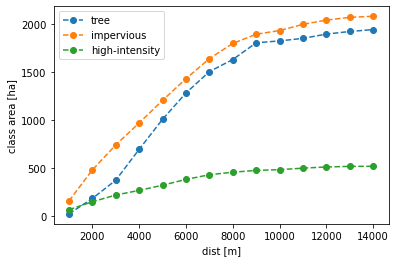

In [105]:
fig, ax = plt.subplots()
for class_val, class_df in total_area_df.groupby(total_area_df.index):
    class_df.plot(x='buffer_dists', y='total_area', style='--o', label=LABEL_DICT[class_val], ax=ax)
plt.xlabel('dist [m]')
plt.ylabel('class area [ha]')
plt.legend()

### TODO:

* radial analysis of LST
* radial analysis of T_air

In [ ]:
import logging
import tempfile
from os import path

import click
import geopandas as gpd
import numpy as np
import pandas as pd
import pylandsat
import salem
import xarray as xr
from rio_toa import brightness_temp

from lausanne_greening_scenarios import geo_utils, settings

DATETIME_FMT = '%Y-%m-%d'

LANDSAT_FILES = ['B3.TIF', 'B4.TIF', 'B5.TIF', 'B10.TIF', 'MTL.txt']
LANDSAT_META_KEYS = ['RADIOMETRIC_RESCALING', 'TIRS_THERMAL_CONSTANTS']
LANDSAT_NODATA = 0

# TODO: the "parameters" should be customizable by means of arguments or a
# settings module
C = 0.005
ndvi_soil = 0.2
ndvi_veg = 0.5
eps_water = 0.991
eps_soil = 0.996
eps_veg = 0.973

lambd = 10.895e-9
rho = 1.439e-2  # 6.626e-34 * 2.998e8 / 1.38e-23


def compute_ndvi(landsat_ds):
    # ground emissivity (bands 4 and 5)
    b4_arr = landsat_ds['red'].values.astype(np.int32)
    b5_arr = landsat_ds['nir'].values.astype(np.int32)
    # nan values and zero division
    b4_plus_b5_arr = b5_arr + b4_arr

    return np.where(b4_plus_b5_arr == 0, LANDSAT_NODATA,
                    (b5_arr - b4_arr) / b4_plus_b5_arr)


def compute_lst(landsat_ds, mtl_dict, water_body_mask):
    # brightness temperature (band 10)
    radio_rescale = mtl_dict['RADIOMETRIC_RESCALING']
    thermal_constants = mtl_dict['TIRS_THERMAL_CONSTANTS']
    bt_arr = brightness_temp.brightness_temp(
        landsat_ds['tirs'].values, radio_rescale['RADIANCE_MULT_BAND_10'],
        radio_rescale['RADIANCE_ADD_BAND_10'],
        thermal_constants['K1_CONSTANT_BAND_10'],
        thermal_constants['K2_CONSTANT_BAND_10']) - 273.15

    ndvi_arr = compute_ndvi(landsat_ds)
    min_ndvi = ndvi_arr.min()
    pv_arr = np.square((ndvi_arr - min_ndvi) / (ndvi_arr.max() - min_ndvi))

    eps_arr = np.zeros_like(pv_arr)
    eps_arr[water_body_mask] = eps_water
    eps_arr[(ndvi_arr < ndvi_soil) & ~water_body_mask] = eps_soil
    mid_cond = (ndvi_arr >= ndvi_soil) & (ndvi_arr <
                                          ndvi_veg) & ~water_body_mask
    pv_mid_arr = pv_arr[mid_cond]
    eps_arr[mid_cond] = eps_veg * pv_mid_arr + eps_soil * (1 - pv_mid_arr) + C
    eps_arr[(ndvi_arr >= ndvi_veg) & ~water_body_mask] = eps_veg

    # land surface temperature (putting it all together)
    # lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    lst_arr = bt_arr / (1 + (lambd * bt_arr / rho) * np.log(eps_arr))
    # correct for potential infinities arising from divisions by zero
    # (landsat 8's nodata)
    # lst_arr[~landsat_mask] = landsat_meta['nodata']
    # return np.nan_to_num(lst_arr, LANDSAT_NODATA)
    return lst_arr


def get_lst_da(landsat_tile,
               ref_geom=None,
               lake_geom=None,
               crs=None,
               roi=False,
               subset_kws=None,
               roi_kws=None):
    product = pylandsat.Product(landsat_tile)

    with tempfile.TemporaryDirectory() as tmp_dir:
        product.download(tmp_dir, files=LANDSAT_FILES)

        landsat_tile_dir = path.join(tmp_dir, landsat_tile)

        scene = pylandsat.Scene(landsat_tile_dir)
        bands = scene.available_bands()
        band_filepaths = [getattr(scene, band).fpath for band in bands]

        # create xarray dataset
        landsat_ds = xr.Dataset({
            band: salem.open_xr_dataset(band_filepath)['data']
            for band, band_filepath in zip(bands, band_filepaths)
        })
    # projection attributes need to be set before any geo-transformation
    proj_attrs = landsat_ds[bands[0]].attrs.copy()
    landsat_ds.attrs = proj_attrs

    # landsat metadata that will be used below
    mtl_dict = scene.mtl

    # crop to the reference extent
    landsat_ds = geo_utils.clip_ds_to_extent(landsat_ds,
                                             geometry=ref_geom,
                                             crs=crs,
                                             roi=roi,
                                             subset_kws=subset_kws,
                                             roi_kws=roi_kws)

    # the lake mask needs to be boolean for NumPy slicing to work properly
    lake_mask = landsat_ds.salem.grid.region_of_interest(geometry=lake_geom,
                                                         crs=crs).astype(bool)

    # LST
    lst_arr = compute_lst(landsat_ds, mtl_dict, lake_mask)

    # assemble the final dataset
    dims = ('y', 'x')
    coords = {
        'x': landsat_ds.salem.grid.x_coord,
        'y': landsat_ds.salem.grid.y_coord
    }
    landsat_features_da = xr.DataArray(lst_arr,
                                       dims=dims,
                                       coords=coords,
                                       attrs=proj_attrs)
    # add the date
    landsat_features_da = landsat_features_da.assign_coords({
        'time':
        pd.to_datetime(mtl_dict['PRODUCT_METADATA']['DATE_ACQUIRED'])
    })

    return landsat_features_da


@click.argument('dst_filepath', type=click.Path())
@click.option('--buffer-dist', default=2000)
def main(landsat_tiles_filepath, agglom_extent_filepath, dst_filepath,
         buffer_dist):
    logger = logging.getLogger(__name__)

    # read list of landsat tiles (product ids) to process
    landsat_tiles = pd.read_csv(landsat_tiles_filepath, header=None)[0]

    # get the agglomeration and lake extents
    agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
    crs = agglom_extent_gdf.crs
    ref_geom = agglom_extent_gdf.loc[0]['geometry'].buffer(buffer_dist)
    lake_geom = agglom_extent_gdf.loc[1]['geometry']

    # process the list of tiles
    datasets = []
    for landsat_tile in landsat_tiles:
        ds = get_lst_da(landsat_tile,
                        ref_geom=ref_geom,
                        lake_geom=lake_geom,
                        crs=crs)
        datasets.append(ds)

    agglom_landsat_ds = xr.concat(datasets, dim='time')
    agglom_landsat_ds.to_netcdf(dst_filepath)
    logger.info("dumped landsat features dataset to %s", dst_filepath)


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format=settings.DEFAULT_LOG_FMT)

    main()


In [ ]:
class_metrics_df = ba.compute_class_metrics_df(metrics=['total_area']).reset_index(level=1)
# class_metrics_df['buffer_dists'] = class_metrics_df['buffer_dists'].apply(lambda s: int(s.split('-')[1]))

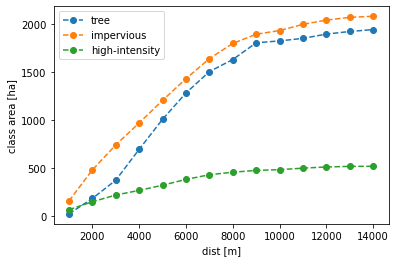

In [90]:
for class_val, class_df in class_metrics_df.groupby(class_metrics_df.index):
    plt.plot(buffer_dists, class_df['total_area'].cumsum(), '--o', label=label_dict[class_val])
plt.xlabel('dist [m]')
plt.ylabel('class area [ha]')
plt.legend()

class_val
1      24.78
1     185.22
1      374.6
1     695.98
1     1007.7
1    1280.92
1    1503.38
1    1628.61
1     1802.3
1    1821.99
1     1848.2
1    1892.81
1    1919.71
1    1939.74
Name: total_area, dtype: object

In [62]:
ba.masks_arr

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [20]:
def plot(lulc_arr, df):
    plt.imshow(np.isin(lulc_arr, df['lucode']))

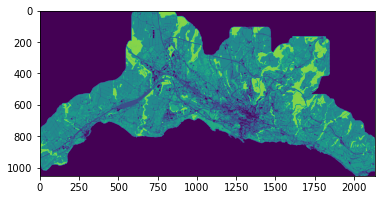

In [8]:
plt.imshow(lulc_arr)

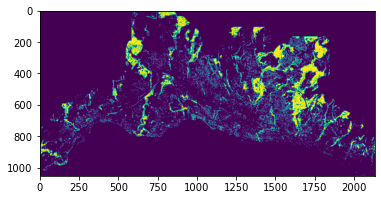

In [21]:
plot(lulc_arr, biophysical_df[biophysical_df['shade'] > .75])

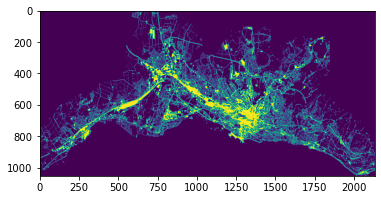

In [23]:
plot(lulc_arr, biophysical_df[(biophysical_df['green_area'] == 0) & (biophysical_df['shade'] < .75)])

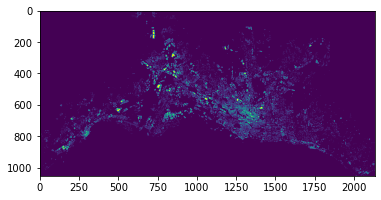

In [ ]:
plot(lulc_arr, biophysical_df[biophysical_df['building_intensity'] > .75])